In [9]:
# imports libraries
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import math
import sklearn.decomposition as dcmp
import pyaudio
import time

%matplotlib inline 

# Grabs the preprocessing and automatic_sync files
sys.path.append(os.path.join(os.pardir,'pythonCode'))
import preprocessing as pp
import automatic_sync as autoS

In [2]:
rawDataPath = os.path.join(os.pardir,'rawData')
files = glob.glob(os.path.join(rawDataPath,'*.wav'))
names = []
        
for name in files:
    fileName = os.path.basename(name).split(".")[0]
    names.append(fileName)

# Determines which cameras will be selected (['Bents'],['Camera Location'],['Motion #'])

filt = (None,None,['17']) # Selects the bent 1 cameras during motion 18

# Applies filter to camera names and returns only selected subset names
audioFiles = pp.getKeys(names,filt);

# Reads the .wav files from the list generted by getKeys
(names,cDataset) = pp.readWAV(rawDataPath,audioFiles);

Opening GP_B2_SU_17 ...
Opening GP_B3_SL_17 ...


In [4]:
# finds the relative offsets between the cameras in counts
offsets = autoS.find_offset(cDataset,names[0],names[1:])

print(offsets) # prints the offsets in counts

{'GP_B3_NU_18': 3475, 'GP_B1_SL_18': 157, 'GP_B1_NL_18': 0, 'GP_B3_SU_18': 2607, 'GP_B2_SU_18': 85198, 'GP_B3_NL_18': 4337, 'GP_B3_SL_18': 3256, 'GP_B1_NU_18': 116, 'GP_B1_SU_18': 535, 'GP_B2_SL_18': 82180}


In [3]:
def sync_dataset(cDataset,names,max_iter = 2):
    '''
    sDataset = sync_dataset(cDataset,names,max_iter = 2). Syncs the input dataset (dictionary) 
    with corresponding keys (names), recursively determines relative offsets using the cross 
    correlation. 
    Inputs:
        cDataset (dict) - dictionary with raw audio data, each key corresponds to an (Ni,2) array of 1D signals.
        names (list) - keys to the dictionary (data will be synced to names[0])
        max_iter (optional) - maximum number of iterations to be performed.
    Outputs:
        sDataset (dict) - synced dataset (each entry has the same length)
        
    Needed Additions (2/5/2016): needs to return out the final offset values!!
    '''
    
    offsets = autoS.find_offset(cDataset,names[0],names[1:])
    
    iter_count = 0
    
    
    while abs(sum(offsets.values())) > 0 and iter_count < max_iter:
        syncData = {}
        startInd = 0
        endInd = np.Inf
    
        for name in names:
            if offsets[name] > startInd:
                startInd = offsets[name]
            if offsets[name]+len(cDataset[name][:,0]) < endInd:
                endInd = offsets[name]+len(cDataset[name][:,0])

        for name in names:
            syncData[name] = cDataset[name][startInd-offsets[name]:endInd-offsets[name],:]
            cDataset[name] = syncData[name] 
            assert len(syncData[name]) == endInd - startInd

        offsets = autoS.find_offset(syncData,names[0],names[1:])
        iter_count += 1
        
    
    assert sum(offsets.values()) == 0, print(fixedOffsets)
    
    return cDataset

In [4]:
sDataset = autoS.sync_dataset(cDataset,names)
print(autoS.find_offset(sDataset,names[0],names[1:]))

{'GP_B2_SU_17': 0, 'GP_B3_SL_17': 0}


In [6]:
#converts dictionary a numpy array for sklearn operations. Takes only the 1st channel of the stereo sound.
x = np.zeros((len(sDataset.keys()),len(sDataset[names[0]][:,0])),dtype='i2',order='C')
count = 0;

for ii in range(0,len(names)):
    x[ii,:]= sDataset[names[ii]][:,0]

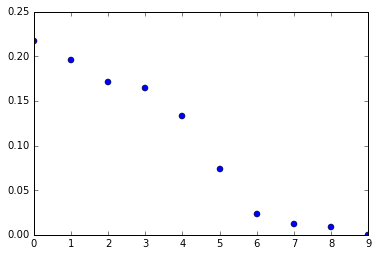

In [7]:
pca = dcmp.PCA(n_components = len(sDataset.keys()))
pca.fit(x)
plt.plot(pca.explained_variance_ratio_,linestyle = 'None',marker = 'o') 

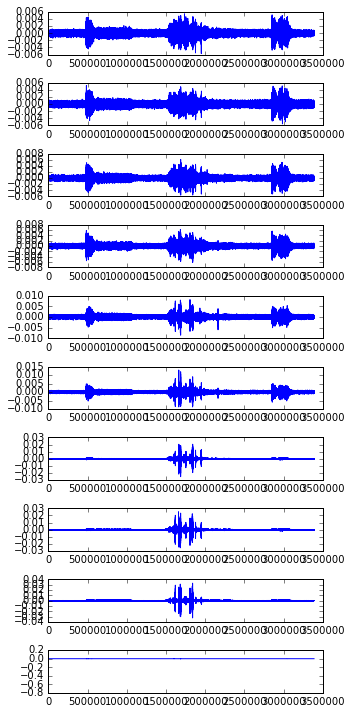

In [10]:
fig = plt.figure(figsize=(5,10))
for i in range(len(sDataset.keys())):
    plt.subplot(10,1,i+1)
    plt.plot(pca.components_[i,:],'b')
    plt.draw
    
fig.tight_layout()

In [ ]:
# the datatype of the pca components are now floats, but the input signals were int16 (dtype = 'i2')
pca.components_.dtype is np.dtype('float64')

In [ ]:
# in order to play the data need to covert back to int16 (dtype = 'i2')
a = pca.components_[1,:]
print(a.dtype)
a = np.array(a, dtype='i2')
print(a.dtype)
# write a program that does this automatically and plays the file 

In [28]:
def play_sound(Fs,input_array):
    ''' play_sound(Fs,input_array). Plays the audio for an array. Converts the signal to int16, 
    converts the signal to bytes and plays using pyaudio.
    Input:
        Fs (i) - frequency of sampling (using a smaller number will play the sound in "slow motion")
        input_array (n,) numpy array signal to be played
    '''
    if input_array.dtype is np.dtype('float64'):
        input_array = np.array(40000*input_array/input_array.max(), dtype='i2',order='C')

    #if input_array.flags['C_CONTIGUOUS'] == False:
    #    input_array = input_array.copy(order='C')
    
    # instantiate PyAudio (1)
    p = pyaudio.PyAudio()
    
    def callback(in_data, frame_count, time_info, status):
        if frame_count % 1500 == 0:
            startInd = max([0,frame_count-15000])
            endInd = min([len(input_array),frame-count-15000])
            data = input_aray(frame_count)
            plt.plot(1/Fs*np.linspace(startInd,endInd,endInd-startInd),input_data[startInd,enInd])
            
        data = input_array[frame_count].tobytes()            
        return (data, pyaudio.paContinue)
    
    # open stream (2), 2 is size in bytes of int16
    stream = p.open(format=p.get_format_from_width(2),
                    channels=1,
                    rate=Fs,
                    output=True,
                    stream_callback=callback)

    # play stream (3), blocking call
    #bytestream = input_array.tobytes()
    #stream.write(bytestream)
    stream.start_stream()
    
    while stream.is_active():
        time.sleep(0.1)
    #    if (round(stream.get_time(),5) % 1) == 0:
    #        print(round(stream.get_time(),5))
        

    # stop stream (4)
    stream.stop_stream()
    stream.close()

    # close PyAudio (5)
    p.terminate()

In [29]:
# plays the sound of the snippet
thisrange = range(1660000,1690000)

a = sDataset[names[0]][thisrange,0]
play_sound(12000,a)

In [7]:
# grabs a small segment of the data that has a few "fracture"sounds.

thisrange = range(1660000,1690000)

print(pca.components_[:,6].dtype is np.dtype('float64'))
a = np.array(40000*pca.components_[6,thisrange,]/pca.components_[6,:].max(), dtype='i2',order='C')
#plt.plot(pca.components_[6,thisrange])
plt.plot(sDataset[names[0]][thisrange,0],'r')

NameError: name 'pca' is not defined

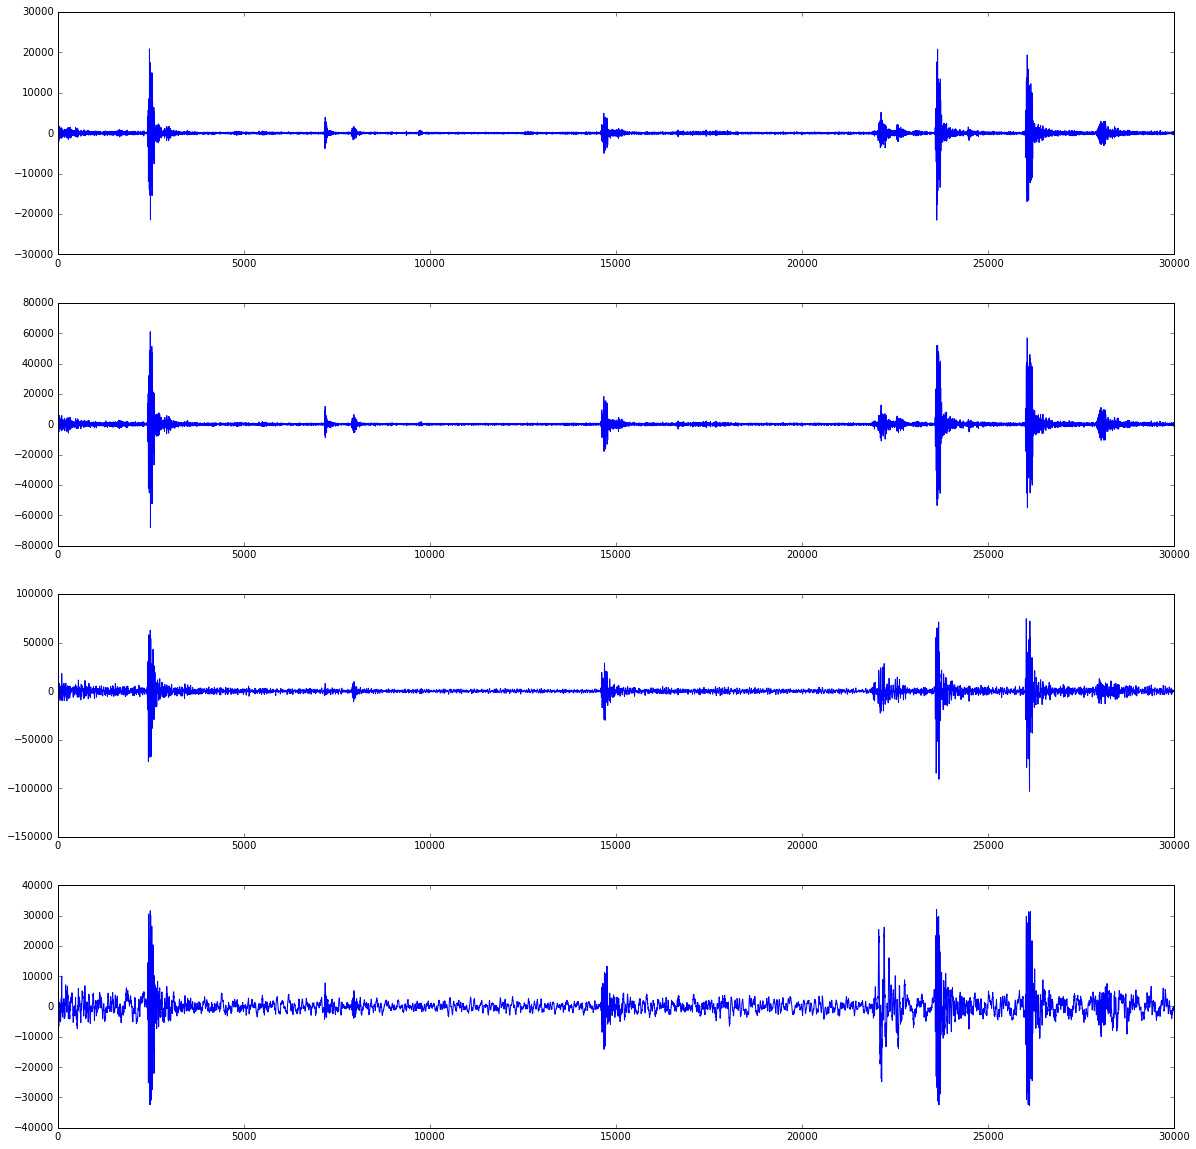

In [18]:
# takes the continuous wavelet transform and plots the results
widths = np.array([1,2,5])
cwtmatr = signal.cwt(a, signal.ricker, widths)
plt.figure(figsize=(20,20))
plt.subplot(4,1,1)
plt.plot(cwtmatr[0])
plt.subplot(4,1,2)
plt.plot(cwtmatr[1])
plt.subplot(4,1,3)
plt.plot(cwtmatr[2])
#plt.plot(cwtmatr.max()*(abs(cwtmatr[0]) > 6*cwtmatr[0].std()),'r')
#plt.imshow(cwtmatr, cmap='YlGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.subplot(4,1,4)
plt.plot(a)
#plt.show()

plt.savefig('waveletTry',format = 'svg')

In [48]:
#trys built in function
peakInd = signal.find_peaks_cwt(a,np.array([1,2,3,4,5,6,7,8]),noise_perc=0.1,min_snr=3,min_length = 6)

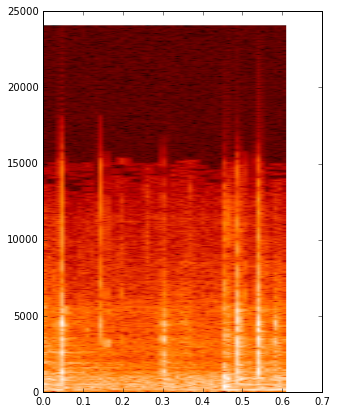

In [75]:
# plots results (needs some tweaking)
plt.figure(figsize=(5,15))
count = 1
             
plt.subplot(1,2,1)
plt.plot(a,'b')
plt.plot(peakInd,a[peakInd],'ro')
plt.xlabel('Counts')
plt.ylabel('Signal')
plt.grid()

plt.subplot(2,1,2)
Pxx, freqs, bins, im = plt.specgram(a, NFFT=1024, Fs=48000, noverlap=512, cmap=plt.cm.gist_heat)
plt.show()
    
plt.draw()

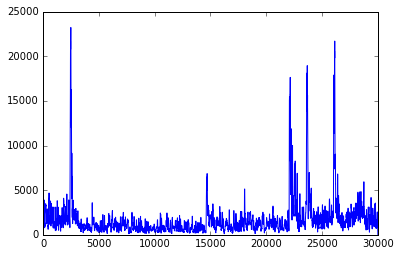

In [79]:
b = signal.medfilt(abs(a), kernel_size=41)
plt.plot(abs(b),'b')

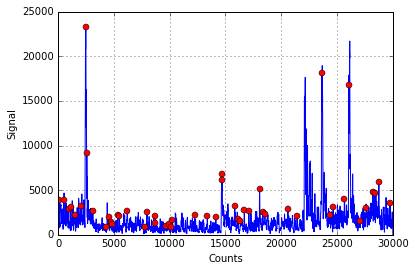

In [84]:
#trys built in function
peakInd = signal.find_peaks_cwt(abs(b),np.array([2,4,8,16,32,64,128]),noise_perc=.1,min_snr=1,min_length = 3,gap_thresh =10)


plt.plot(abs(b),'b')
plt.plot(peakInd,abs(b[peakInd]),'ro')
plt.xlabel('Counts')
plt.ylabel('Signal')
plt.grid()